In [ ]:
# Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%pip install ultralytics

In [ ]:
!pip install deep_sort_realtime

In [35]:
import cv2
import math
import torch
import numpy as np
from  ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort
from google.colab.patches import cv2_imshow
from google.colab import files
import matplotlib.pyplot as plt

In [36]:
print(torch.cuda.is_available())
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())

True
Tesla T4


In [ ]:
model_path = r"yolov8n.pt"
model = YOLO(model_path)
tracker = DeepSort(max_age=25)

In [38]:
video_name = "cars"
video_path = r"/content/drive/MyDrive/test_video/"+video_name+".mp4"
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Error : Could not open video")
    exit()
else:
    print("Video is opened and working")

Video is opened and working


In [39]:
# Homographic conditions
meters_per_pixel = 50/360 # Consider 1 m = 8px
print(meters_per_pixel)

0.1388888888888889


In [40]:
# Variables
car_coordinates = {}
roi_coords = []
latest_boxes_coords={}
roi_polygon = np.array([[245, 0], [330, 0], [740, 360], [0, 360]], np.int32).reshape((-1, 1, 2))

stall_cars = []
opposite_cars = []
overspeed = {}
Heavy_vehicles = []
counted_vehicle = set()
vehicle_count ={'Car':0, 'Motorcycle':0, 'Bus':0, 'Heavy':0}
collision_record = {}

In [41]:
def alert(car_id, reason):
    if(reason=="Opposite_direction"):
        print(f"{car_id} is moving in Opposite Direction.")
    elif(reason=="Stalled"):
        print(f"{car_id} is stalled.")
    elif(reason=="Overspeed"):
        print(f"{car_id} is Overspeeding.")
    elif(reason=="Heavy Vehicle"):
        print(f"{car_id} is a Heavy Vehicle.")
    else:
        print(f"{car_id} is ok")

In [42]:
def heavy_vehicle(car_id):
    if(car_id not in Heavy_vehicles):
        Heavy_vehicles.append(car_id)
        alert(car_id, "Heavy Vehicle")

In [43]:
def vehicle_count_fn(class_id):
    if(class_id == 2):
        vehicle_count['Car'] += 1
    elif(class_id == 3):
        vehicle_count['Motorcycle'] += 1
    elif(class_id == 5):
        vehicle_count['Bus'] += 1
    elif(class_id == 7):
        vehicle_count['Heavy'] += 1

In [44]:
def obj_Detection(results, detections):
    for box in results.boxes:
        x1, y1, x2, y2 = map(int,box.xyxy[0])
        class_id = int(box.cls[0])
        if class_id not in [2,3,5,7]:
          # 2 = Car, 3 = Bike/Motercycle, 4 = Bus, 7 = Truck.
          continue
        class_name = results.names[class_id]
        confidence = float(box.conf[0])

        detections.append(([x1,y1,x2-x1,y2-y1], confidence, class_name))

In [45]:
def calculate_speed(car_coordinates, fps, meters_per_pixel):
    speeds = []
    for i in range(1, len(car_coordinates)):
        x1, y1 = car_coordinates[i-1]
        x2, y2 = car_coordinates[i]
        pixel_dist = math.hypot(x2 - x1, y2 - y1)
        distance_m = pixel_dist * meters_per_pixel
        time_s = 1 / fps
        speed_mps = distance_m / time_s
        speed_kmph = speed_mps * 3.6
        speeds.append(speed_kmph)
    if speeds:
        return sum(speeds)/len(speeds)
    else:
        return 0.0

In [46]:
def is_in_polygon_roi(x, y, polygon):
    return cv2.pointPolygonTest(polygon, (x, y), False) >= 0

In [47]:
def draw_Tracks(tracks,frame, roi_polygon, counted_vehicles):
    cv2.polylines(frame, [roi_polygon], isClosed=True, color=(255, 0, 0), thickness=1)
    for track in tracks:
        if not track.is_confirmed():
            continue
        track_id = track.track_id
        ltrb = track.to_ltrb()
        x1, y1, x2, y2 = map(int, ltrb)
        class_name = track.get_det_class()
        if(class_name == "truck"):
            heavy_vehicle(track_id)
        cx = int((x1 + x2) / 2)
        cy = int((y1 + y2) / 2)
        if not is_in_polygon_roi(cx, cy, roi_polygon):
              continue


        if track_id not in counted_vehicles:
            if class_name == "car":
                vehicle_count['Car'] += 1
            elif class_name == "motorcycle":
                vehicle_count['Motorcycle'] += 1
            elif class_name == "bus":
                vehicle_count['Bus'] += 1
            elif class_name == "truck": # Heavy
                vehicle_count['Heavy'] += 1

            counted_vehicles.add(track_id)


        car_coords_fn(track_id, x1, y1, x2, y2)
        speed = calculate_speed(car_coordinates[track_id], fps = 30, meters_per_pixel=meters_per_pixel)
        if(speed > 70 and track_id not in overspeed):
            alert(track_id,"Overspeed")
            overspeed[track_id] = speed

        label = f"ID {track_id} | {class_name} | {speed:.1f} km/h"

        if track_id in stall_cars:
            color = (0,255,255)
        elif track_id in opposite_cars:
            color = (0,0,255)
        elif track_id in Heavy_vehicles:
            color = (255,0,0)
        elif speed > 60:
            color = (0,165,255) # Overspeeding
        else:
            color = (0,255,0) # Grren for Normal Vehicle


        cv2.rectangle(frame, (x1,y1), (x2,y2), color, 1)
        cv2.putText(frame, label, (x1, y1 - 10,), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)


In [48]:
src_pts = np.array([[245,0],[330,0],[740,360],[0,360]], np.float32)
def get_bev_homography(src_pts, dst_width = 640, dst_height = 360):
  dst_pts = np.float32([
      [0,0],
      [dst_width,0],
      [dst_width,dst_height],
      [0,dst_height]
  ])
  H, _ = cv2.findHomography(src_pts, dst_pts)
  return H, (dst_width, dst_height)
def apply_bev_transform(point, H):
  point = np.array([[point]], dtype='float32')
  transformed = cv2.perspectiveTransform(point, H)
  return transformed[0][0]
H, bev_size = get_bev_homography(src_pts)

In [49]:
def car_coords_fn(track_id, x1, y1, x2, y2):
    center_x = int((x1 + x2)/2)
    center_y = int((y1 + y2)/2)
    bev_x, bev_y = apply_bev_transform((center_x, center_y), H)
    if track_id not in car_coordinates:
        car_coordinates[track_id] = []
    if len(car_coordinates[track_id]) >= 20:
        car_coordinates[track_id].pop(0)
    car_coordinates[track_id].append([bev_x, bev_y])
    detect_car_movement(car_coordinates)

In [50]:
def stall_vehicle_detection(x1,x2,y1,y2,car_id):
  def stall_movement_fn(car_coordinates, car_id):
      def eucledian(base_coord, pt):
          pt1 = (base_coord[0] - pt[0])**2
          pt2 = (base_coord[1] - pt[1])**2
          dist = math.sqrt(pt1+pt2)
          return dist

      coords = car_coordinates[car_id]
      stalled = True
      if(len(coords) > 10):
          recent_coords = coords[-10:]
          base_coord = recent_coords[0]
          for pt in recent_coords[1:]:
              distance = eucledian(base_coord, pt)
              if distance >= 7.2: #pixel_threshold 1 m = 7.2px
                  stalled = False
                  break
      else:
          stalled = False

      return stalled

  if(x2-x1 == 0 and y2-y1 == 0):
            if(stall_movement_fn(car_coordinates, car_id)):
                if(car_id not in stall_cars):
                    stall_cars.append(car_id)
                    alert(car_id,"Stalled")



In [51]:
def opposite_vehicles(x1,x2,y1,y2,expected,threshold,car_id):

    def normalize_vector(v):
          mag = math.sqrt(v[0]**2 + v[1]**2)
          if(mag!=0):
              return [v[0]/mag, v[1]/mag]
          else:
              return [0,0]
    def cosine_similarity(movment_vec, expected):
          dot_num = (movment_vec[0] * expected[0]) + (movment_vec[1] * expected[1])
          mag1 = math.sqrt((movment_vec[0]**2)+(movment_vec[1]**2))
          mag2 = math.sqrt((expected[0]**2)+(expected[1]**2))
          if(mag1 and mag2):
              return dot_num / (mag1 * mag2)
          else:
              return 1

    movment = [x2-x1, y2-y1]
    movement_unit = normalize_vector(movment)
    similarity = cosine_similarity(movement_unit, expected)

    if(similarity < -threshold):
        if(car_id not in opposite_cars):
            alert(car_id,"Opposite_direction")
            opposite_cars.append(car_id)

In [52]:
def detect_car_movement(car_coordinates, expected = [0,-1], threshold = 0.2):
    for car_id, coords in car_coordinates.items():

        if(len(coords)<5):
            continue

        x1, y1 = coords[-5]
        x2, y2 = coords[-1]

        opposite_vehicles(x1,x2,y1,y2,expected,threshold,car_id)
        stall_vehicle_detection(x1,x2,y1,y2,car_id)


In [53]:
def accident_detection():
  def cal_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = max(boxA[2], boxB[2])
    yB = max(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    if  interArea == 0:
     return 0.0

    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou
  for id1 in stall_cars:
      for id2 in opposite_cars:
          if(id1 == id2):
              continue
          if id1 not in latest_boxes_coords or id2 not in latest_boxes_coords:
              continue
          box1 = latest_boxes_coords[id1]
          box2 = latest_boxes_coords[id2]
          iou = cal_iou(box1, box2)
          if iou > 0.2:
            collision_record[id1] = [id2]
            print(f"Possible Accident/Collision between car {id1} and car {id2}")


---ROI---



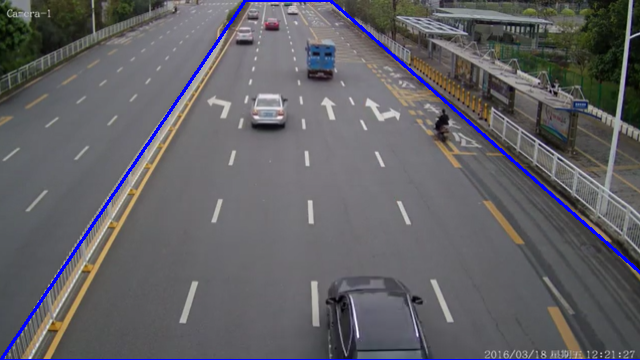

In [54]:
def draw_roi():
  roi_polygon = np.array([[245,0],[330,0],[740,360],[0,360]], np.int32)
  roi_polygon = roi_polygon.reshape((-1,1,2))
  return roi_polygon
roi_polygon = draw_roi()
print("\n---ROI---\n")
img_path = "/content/drive/MyDrive/test_image/cars_img.png"
img = cv2.imread(img_path)
resized_img = cv2.resize(img, (640, 360))
cv2.polylines(resized_img, [roi_polygon], isClosed=True, color=(255, 0, 0), thickness=2)
cv2_imshow(resized_img)

In [55]:
# To save the output.
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
output_vdo = "output_new"+video_name+".mp4"
out = cv2.VideoWriter(output_vdo, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

In [56]:
while True:
   ret, frame = cap.read()
   if not ret:
       break
   results = model(frame, conf = 0.7)[0]

   detections = []
   obj_Detection(results, detections)

   tracks = tracker.update_tracks(detections, frame = frame)
   draw_Tracks(tracks,frame,roi_polygon, counted_vehicle)
   accident_detection()
   out.write(frame)

out.release()
files.download(output_vdo)
cap.release()


0: 384x640 (no detections), 10.1ms
Speed: 1.5ms preprocess, 10.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 6.8ms
Speed: 1.4ms preprocess, 6.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 6.5ms
Speed: 1.5ms preprocess, 6.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bus, 6.5ms
Speed: 1.4ms preprocess, 6.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 6.6ms
Speed: 1.6ms preprocess, 6.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 6.7ms
Speed: 1.4ms preprocess, 6.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 6.5ms
Speed: 1.4ms preprocess, 6.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 6.5ms
Speed: 1.4ms preprocess, 6.5ms inference, 0.6ms postprocess per im

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [57]:
total_cars = len(car_coordinates)
print(f"Total Cars = {total_cars}")
print("--"*130)

for track_id, coords in car_coordinates.items():
    print(f"\nCar Id {track_id} -> {coords}")
    speed = calculate_speed(coords, fps = 30, meters_per_pixel=meters_per_pixel)
    print(f"Speed of car Id {track_id} : {speed:.2f} km/h.")

Total Cars = 38
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Car Id 5 -> [[np.float32(100.59912), np.float32(197.2669)], [np.float32(100.59912), np.float32(197.2669)], [np.float32(99.052155), np.float32(194.93236)], [np.float32(99.052155), np.float32(194.93236)], [np.float32(101.43521), np.float32(192.54517)], [np.float32(99.8625), np.float32(190.10356)], [np.float32(99.8625), np.float32(190.10356)], [np.float32(98.253525), np.float32(187.60564)], [np.float32(102.30986), np.float32(187.60564)], [np.float32(102.30986), np.float32(187.60564)], [np.float32(100.71066), np.float32(185.04942)], [np.float32(100.71066), np.float32(185.04942)], [np.float32(99.07371), np.float32(182.43288)], [np.float32(97.397644), np.float32(179.7538)], [np.float32(97.397644), np.float32(179.7538)]

In [58]:
print("\n---Total Vehicle Count---\n")
for vehicle in vehicle_count:
  print(f"{vehicle} : {vehicle_count[vehicle]}")
print("\n\n---Stalled Vehicle---\n")
for s_car in stall_cars:
    print(f"Car Id {s_car} Stalled.")
print("\n\n---Opposite Vehicle---\n")
for op_car in opposite_cars:
    print(f"Car Id {op_car} is moving in opposite direction.")
print("\n\n---Overspeed Vehicle---\n")
for overspd in overspeed:
    print(f"Car Id {overspd} is overspeeding.")
print("\n\n---Heavy Vehicle---\n")
for heavy_veh in Heavy_vehicles:
    print(f"Car Id {heavy_veh} is a heavy vehicle.")
print("\n\n---Accident Detections---\n")
for car in collision_record:
    print(f"Car Id {car} and {collision_record[car]}.")


---Total Vehicle Count---

Car : 34
Motorcycle : 0
Bus : 4
Heavy : 0


---Stalled Vehicle---

Car Id 29 Stalled.
Car Id 62 Stalled.
Car Id 83 Stalled.
Car Id 93 Stalled.
Car Id 102 Stalled.
Car Id 97 Stalled.
Car Id 104 Stalled.


---Opposite Vehicle---

Car Id 13 is moving in opposite direction.
Car Id 18 is moving in opposite direction.
Car Id 19 is moving in opposite direction.
Car Id 24 is moving in opposite direction.
Car Id 29 is moving in opposite direction.
Car Id 49 is moving in opposite direction.
Car Id 55 is moving in opposite direction.
Car Id 69 is moving in opposite direction.
Car Id 77 is moving in opposite direction.
Car Id 93 is moving in opposite direction.
Car Id 97 is moving in opposite direction.
Car Id 88 is moving in opposite direction.
Car Id 108 is moving in opposite direction.
Car Id 137 is moving in opposite direction.


---Overspeed Vehicle---

Car Id 13 is overspeeding.
Car Id 24 is overspeeding.
Car Id 77 is overspeeding.


---Heavy Vehicle---



---Acci